In [1]:
#------# Import libraries and datasets #------#

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import datasets as dts
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import gc
import random
import spacy
%matplotlib inline

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler


from transformers import BertModel,AutoModel
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score, f1_score

In [2]:
dataset = dts.load_dataset('lex_glue','unfair_tos')

Found cached dataset lex_glue (/home/anas/.cache/huggingface/datasets/lex_glue/unfair_tos/1.0.0/8a66420941bf6e77a7ddd4da4d3bfb7ba88ef48c1d55302a568ac650a095ca3a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
train_dataset = pd.DataFrame.from_dict(dataset["train"])
val_dataset = pd.DataFrame.from_dict(dataset["validation"])
test_dataset = pd.DataFrame.from_dict(dataset["test"])

stop_words = list(stopwords.words('english'))

In [4]:
definitions = {"Limitation of liability": "this clause stipulates that the duty to pay damages is limited or excluded, for certain kind of losses, under certain conditions. "
               , "Unilateral termination": "this clause gives provider the right to suspend and/or terminate the service and/or the contract, and sometimes details the circumstances under which the provider claims to have a right to do so."
               , "Unilateral change": "this clause specifies the conditions under which the service provider could amend and modify the terms of service and/or the service itself."
               , "Content removal": "this clause gives the provider a right to modify/delete user’s content, including in-app purchases, and sometimes specifies the conditions under which the service provider may do so."
               , "Contract by using": "this clause stipulates that the consumer is bound by the terms of use of a specific service, simply by using the service, without even being required to mark that he or she has read and accepted them."
               , "Choice of law": "this clause specifies what law will govern the contract, meaning also what law will be applied in potential adjudication of a dispute arising under the contract."
               , "Jurisdiction": "this selection clause requires or allows the parties to resolve their disputes through an arbitration process, before the case could go to court."
               , "Arbitration": "this forum selection clause requires or allows the parties to resolve their disputes through an arbitration process, before the case could go to court however, such a clause may or may not specify that arbitration should occur within a specific jurisdiction. "}
label_to_def = {
    0 : "Limitation of liability",
    1 : "Unilateral termination",
    2 : "Unilateral change",
    3 : "Content removal",
    4 : "Contract by using",
    5 : "Choice of law",
    6 : "Jurisdiction",
    7 : "Arbitration"
}

entail_con = ["entails"]

In [5]:
def convert_to_entailment(dataset,defs,lab2def,ent_con):
    new_dataset = {"text":[],"labels":[],"str_labels":[]}
    num_text = len(dataset["text"])
    nlp = spacy.load("en_core_web_sm")
    max_len = 0
    for i in range(0,num_text):
        print (i,"/",num_text)
        old_string = dataset["text"][i]
        random_number = random.randint(0, len(ent_con)) - 1
        doc = nlp(old_string)
        old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
        for j in range(0,8):
            new_string = old_string + " " + ent_con[random_number] + " " + definitions[label_to_def[j]]
            new_dataset["text"].append(new_string)
            new_dataset["str_labels"].append(str(dataset["labels"][i]))
            if j in dataset["labels"][i]:
                new_dataset["labels"].append([0,1])
            else:
                new_dataset["labels"].append([1,0])
            
            doc2 = nlp(new_string)
            if len(doc2) > max_len :
                max_len = len(doc2)
                
    
    return new_dataset,max_len

train_dataset_ent, train_max = convert_to_entailment(train_dataset,definitions,label_to_def,entail_con)
val_dataset_ent, val_max = convert_to_entailment(val_dataset,definitions,label_to_def,entail_con)
test_dataset_ent, test_max = convert_to_entailment(test_dataset,definitions,label_to_def,entail_con)

print (train_max, val_max, test_max)

0 / 5532
1 / 5532
2 / 5532
3 / 5532
4 / 5532
5 / 5532
6 / 5532
7 / 5532
8 / 5532
9 / 5532
10 / 5532
11 / 5532
12 / 5532
13 / 5532
14 / 5532
15 / 5532
16 / 5532
17 / 5532
18 / 5532
19 / 5532
20 / 5532
21 / 5532
22 / 5532
23 / 5532
24 / 5532
25 / 5532
26 / 5532
27 / 5532
28 / 5532
29 / 5532
30 / 5532
31 / 5532
32 / 5532
33 / 5532
34 / 5532
35 / 5532
36 / 5532
37 / 5532
38 / 5532
39 / 5532
40 / 5532
41 / 5532
42 / 5532
43 / 5532
44 / 5532
45 / 5532
46 / 5532
47 / 5532
48 / 5532
49 / 5532
50 / 5532
51 / 5532
52 / 5532
53 / 5532
54 / 5532
55 / 5532
56 / 5532
57 / 5532
58 / 5532
59 / 5532
60 / 5532
61 / 5532
62 / 5532
63 / 5532
64 / 5532
65 / 5532
66 / 5532
67 / 5532
68 / 5532
69 / 5532
70 / 5532
71 / 5532
72 / 5532
73 / 5532
74 / 5532
75 / 5532
76 / 5532
77 / 5532
78 / 5532
79 / 5532
80 / 5532
81 / 5532
82 / 5532
83 / 5532
84 / 5532
85 / 5532
86 / 5532
87 / 5532
88 / 5532
89 / 5532
90 / 5532
91 / 5532
92 / 5532
93 / 5532
94 / 5532
95 / 5532
96 / 5532
97 / 5532
98 / 5532
99 / 5532
100 / 5532

756 / 5532
757 / 5532
758 / 5532
759 / 5532
760 / 5532
761 / 5532
762 / 5532
763 / 5532
764 / 5532
765 / 5532
766 / 5532
767 / 5532
768 / 5532
769 / 5532
770 / 5532
771 / 5532
772 / 5532
773 / 5532
774 / 5532
775 / 5532
776 / 5532
777 / 5532
778 / 5532
779 / 5532
780 / 5532
781 / 5532
782 / 5532
783 / 5532
784 / 5532
785 / 5532
786 / 5532
787 / 5532
788 / 5532
789 / 5532
790 / 5532
791 / 5532
792 / 5532
793 / 5532
794 / 5532
795 / 5532
796 / 5532
797 / 5532
798 / 5532
799 / 5532
800 / 5532
801 / 5532
802 / 5532
803 / 5532
804 / 5532
805 / 5532
806 / 5532
807 / 5532
808 / 5532
809 / 5532
810 / 5532
811 / 5532
812 / 5532
813 / 5532
814 / 5532
815 / 5532
816 / 5532
817 / 5532
818 / 5532
819 / 5532
820 / 5532
821 / 5532
822 / 5532
823 / 5532
824 / 5532
825 / 5532
826 / 5532
827 / 5532
828 / 5532
829 / 5532
830 / 5532
831 / 5532
832 / 5532
833 / 5532
834 / 5532
835 / 5532
836 / 5532
837 / 5532
838 / 5532
839 / 5532
840 / 5532
841 / 5532
842 / 5532
843 / 5532
844 / 5532
845 / 5532
846 / 5532

1463 / 5532
1464 / 5532
1465 / 5532
1466 / 5532
1467 / 5532
1468 / 5532
1469 / 5532
1470 / 5532
1471 / 5532
1472 / 5532
1473 / 5532
1474 / 5532
1475 / 5532
1476 / 5532
1477 / 5532
1478 / 5532
1479 / 5532
1480 / 5532
1481 / 5532
1482 / 5532
1483 / 5532
1484 / 5532
1485 / 5532
1486 / 5532
1487 / 5532
1488 / 5532
1489 / 5532
1490 / 5532
1491 / 5532
1492 / 5532
1493 / 5532
1494 / 5532
1495 / 5532
1496 / 5532
1497 / 5532
1498 / 5532
1499 / 5532
1500 / 5532
1501 / 5532
1502 / 5532
1503 / 5532
1504 / 5532
1505 / 5532
1506 / 5532
1507 / 5532
1508 / 5532
1509 / 5532
1510 / 5532
1511 / 5532
1512 / 5532
1513 / 5532
1514 / 5532
1515 / 5532
1516 / 5532
1517 / 5532
1518 / 5532
1519 / 5532
1520 / 5532
1521 / 5532
1522 / 5532
1523 / 5532
1524 / 5532
1525 / 5532
1526 / 5532
1527 / 5532
1528 / 5532
1529 / 5532
1530 / 5532
1531 / 5532
1532 / 5532
1533 / 5532
1534 / 5532
1535 / 5532
1536 / 5532
1537 / 5532
1538 / 5532
1539 / 5532
1540 / 5532
1541 / 5532
1542 / 5532
1543 / 5532
1544 / 5532
1545 / 5532
1546

2147 / 5532
2148 / 5532
2149 / 5532
2150 / 5532
2151 / 5532
2152 / 5532
2153 / 5532
2154 / 5532
2155 / 5532
2156 / 5532
2157 / 5532
2158 / 5532
2159 / 5532
2160 / 5532
2161 / 5532
2162 / 5532
2163 / 5532
2164 / 5532
2165 / 5532
2166 / 5532
2167 / 5532
2168 / 5532
2169 / 5532
2170 / 5532
2171 / 5532
2172 / 5532
2173 / 5532
2174 / 5532
2175 / 5532
2176 / 5532
2177 / 5532
2178 / 5532
2179 / 5532
2180 / 5532
2181 / 5532
2182 / 5532
2183 / 5532
2184 / 5532
2185 / 5532
2186 / 5532
2187 / 5532
2188 / 5532
2189 / 5532
2190 / 5532
2191 / 5532
2192 / 5532
2193 / 5532
2194 / 5532
2195 / 5532
2196 / 5532
2197 / 5532
2198 / 5532
2199 / 5532
2200 / 5532
2201 / 5532
2202 / 5532
2203 / 5532
2204 / 5532
2205 / 5532
2206 / 5532
2207 / 5532
2208 / 5532
2209 / 5532
2210 / 5532
2211 / 5532
2212 / 5532
2213 / 5532
2214 / 5532
2215 / 5532
2216 / 5532
2217 / 5532
2218 / 5532
2219 / 5532
2220 / 5532
2221 / 5532
2222 / 5532
2223 / 5532
2224 / 5532
2225 / 5532
2226 / 5532
2227 / 5532
2228 / 5532
2229 / 5532
2230

2833 / 5532
2834 / 5532
2835 / 5532
2836 / 5532
2837 / 5532
2838 / 5532
2839 / 5532
2840 / 5532
2841 / 5532
2842 / 5532
2843 / 5532
2844 / 5532
2845 / 5532
2846 / 5532
2847 / 5532
2848 / 5532
2849 / 5532
2850 / 5532
2851 / 5532
2852 / 5532
2853 / 5532
2854 / 5532
2855 / 5532
2856 / 5532
2857 / 5532
2858 / 5532
2859 / 5532
2860 / 5532
2861 / 5532
2862 / 5532
2863 / 5532
2864 / 5532
2865 / 5532
2866 / 5532
2867 / 5532
2868 / 5532
2869 / 5532
2870 / 5532
2871 / 5532
2872 / 5532
2873 / 5532
2874 / 5532
2875 / 5532
2876 / 5532
2877 / 5532
2878 / 5532
2879 / 5532
2880 / 5532
2881 / 5532
2882 / 5532
2883 / 5532
2884 / 5532
2885 / 5532
2886 / 5532
2887 / 5532
2888 / 5532
2889 / 5532
2890 / 5532
2891 / 5532
2892 / 5532
2893 / 5532
2894 / 5532
2895 / 5532
2896 / 5532
2897 / 5532
2898 / 5532
2899 / 5532
2900 / 5532
2901 / 5532
2902 / 5532
2903 / 5532
2904 / 5532
2905 / 5532
2906 / 5532
2907 / 5532
2908 / 5532
2909 / 5532
2910 / 5532
2911 / 5532
2912 / 5532
2913 / 5532
2914 / 5532
2915 / 5532
2916

3517 / 5532
3518 / 5532
3519 / 5532
3520 / 5532
3521 / 5532
3522 / 5532
3523 / 5532
3524 / 5532
3525 / 5532
3526 / 5532
3527 / 5532
3528 / 5532
3529 / 5532
3530 / 5532
3531 / 5532
3532 / 5532
3533 / 5532
3534 / 5532
3535 / 5532
3536 / 5532
3537 / 5532
3538 / 5532
3539 / 5532
3540 / 5532
3541 / 5532
3542 / 5532
3543 / 5532
3544 / 5532
3545 / 5532
3546 / 5532
3547 / 5532
3548 / 5532
3549 / 5532
3550 / 5532
3551 / 5532
3552 / 5532
3553 / 5532
3554 / 5532
3555 / 5532
3556 / 5532
3557 / 5532
3558 / 5532
3559 / 5532
3560 / 5532
3561 / 5532
3562 / 5532
3563 / 5532
3564 / 5532
3565 / 5532
3566 / 5532
3567 / 5532
3568 / 5532
3569 / 5532
3570 / 5532
3571 / 5532
3572 / 5532
3573 / 5532
3574 / 5532
3575 / 5532
3576 / 5532
3577 / 5532
3578 / 5532
3579 / 5532
3580 / 5532
3581 / 5532
3582 / 5532
3583 / 5532
3584 / 5532
3585 / 5532
3586 / 5532
3587 / 5532
3588 / 5532
3589 / 5532
3590 / 5532
3591 / 5532
3592 / 5532
3593 / 5532
3594 / 5532
3595 / 5532
3596 / 5532
3597 / 5532
3598 / 5532
3599 / 5532
3600

4200 / 5532
4201 / 5532
4202 / 5532
4203 / 5532
4204 / 5532
4205 / 5532
4206 / 5532
4207 / 5532
4208 / 5532
4209 / 5532
4210 / 5532
4211 / 5532
4212 / 5532
4213 / 5532
4214 / 5532
4215 / 5532
4216 / 5532
4217 / 5532
4218 / 5532
4219 / 5532
4220 / 5532
4221 / 5532
4222 / 5532
4223 / 5532
4224 / 5532
4225 / 5532
4226 / 5532
4227 / 5532
4228 / 5532
4229 / 5532
4230 / 5532
4231 / 5532
4232 / 5532
4233 / 5532
4234 / 5532
4235 / 5532
4236 / 5532
4237 / 5532
4238 / 5532
4239 / 5532
4240 / 5532
4241 / 5532
4242 / 5532
4243 / 5532
4244 / 5532
4245 / 5532
4246 / 5532
4247 / 5532
4248 / 5532
4249 / 5532
4250 / 5532
4251 / 5532
4252 / 5532
4253 / 5532
4254 / 5532
4255 / 5532
4256 / 5532
4257 / 5532
4258 / 5532
4259 / 5532
4260 / 5532
4261 / 5532
4262 / 5532
4263 / 5532
4264 / 5532
4265 / 5532
4266 / 5532
4267 / 5532
4268 / 5532
4269 / 5532
4270 / 5532
4271 / 5532
4272 / 5532
4273 / 5532
4274 / 5532
4275 / 5532
4276 / 5532
4277 / 5532
4278 / 5532
4279 / 5532
4280 / 5532
4281 / 5532
4282 / 5532
4283

4883 / 5532
4884 / 5532
4885 / 5532
4886 / 5532
4887 / 5532
4888 / 5532
4889 / 5532
4890 / 5532
4891 / 5532
4892 / 5532
4893 / 5532
4894 / 5532
4895 / 5532
4896 / 5532
4897 / 5532
4898 / 5532
4899 / 5532
4900 / 5532
4901 / 5532
4902 / 5532
4903 / 5532
4904 / 5532
4905 / 5532
4906 / 5532
4907 / 5532
4908 / 5532
4909 / 5532
4910 / 5532
4911 / 5532
4912 / 5532
4913 / 5532
4914 / 5532
4915 / 5532
4916 / 5532
4917 / 5532
4918 / 5532
4919 / 5532
4920 / 5532
4921 / 5532
4922 / 5532
4923 / 5532
4924 / 5532
4925 / 5532
4926 / 5532
4927 / 5532
4928 / 5532
4929 / 5532
4930 / 5532
4931 / 5532
4932 / 5532
4933 / 5532
4934 / 5532
4935 / 5532
4936 / 5532
4937 / 5532
4938 / 5532
4939 / 5532
4940 / 5532
4941 / 5532
4942 / 5532
4943 / 5532
4944 / 5532
4945 / 5532
4946 / 5532
4947 / 5532
4948 / 5532
4949 / 5532
4950 / 5532
4951 / 5532
4952 / 5532
4953 / 5532
4954 / 5532
4955 / 5532
4956 / 5532
4957 / 5532
4958 / 5532
4959 / 5532
4960 / 5532
4961 / 5532
4962 / 5532
4963 / 5532
4964 / 5532
4965 / 5532
4966

44 / 2275
45 / 2275
46 / 2275
47 / 2275
48 / 2275
49 / 2275
50 / 2275
51 / 2275
52 / 2275
53 / 2275
54 / 2275
55 / 2275
56 / 2275
57 / 2275
58 / 2275
59 / 2275
60 / 2275
61 / 2275
62 / 2275
63 / 2275
64 / 2275
65 / 2275
66 / 2275
67 / 2275
68 / 2275
69 / 2275
70 / 2275
71 / 2275
72 / 2275
73 / 2275
74 / 2275
75 / 2275
76 / 2275
77 / 2275
78 / 2275
79 / 2275
80 / 2275
81 / 2275
82 / 2275
83 / 2275
84 / 2275
85 / 2275
86 / 2275
87 / 2275
88 / 2275
89 / 2275
90 / 2275
91 / 2275
92 / 2275
93 / 2275
94 / 2275
95 / 2275
96 / 2275
97 / 2275
98 / 2275
99 / 2275
100 / 2275
101 / 2275
102 / 2275
103 / 2275
104 / 2275
105 / 2275
106 / 2275
107 / 2275
108 / 2275
109 / 2275
110 / 2275
111 / 2275
112 / 2275
113 / 2275
114 / 2275
115 / 2275
116 / 2275
117 / 2275
118 / 2275
119 / 2275
120 / 2275
121 / 2275
122 / 2275
123 / 2275
124 / 2275
125 / 2275
126 / 2275
127 / 2275
128 / 2275
129 / 2275
130 / 2275
131 / 2275
132 / 2275
133 / 2275
134 / 2275
135 / 2275
136 / 2275
137 / 2275
138 / 2275
139 / 2275


794 / 2275
795 / 2275
796 / 2275
797 / 2275
798 / 2275
799 / 2275
800 / 2275
801 / 2275
802 / 2275
803 / 2275
804 / 2275
805 / 2275
806 / 2275
807 / 2275
808 / 2275
809 / 2275
810 / 2275
811 / 2275
812 / 2275
813 / 2275
814 / 2275
815 / 2275
816 / 2275
817 / 2275
818 / 2275
819 / 2275
820 / 2275
821 / 2275
822 / 2275
823 / 2275
824 / 2275
825 / 2275
826 / 2275
827 / 2275
828 / 2275
829 / 2275
830 / 2275
831 / 2275
832 / 2275
833 / 2275
834 / 2275
835 / 2275
836 / 2275
837 / 2275
838 / 2275
839 / 2275
840 / 2275
841 / 2275
842 / 2275
843 / 2275
844 / 2275
845 / 2275
846 / 2275
847 / 2275
848 / 2275
849 / 2275
850 / 2275
851 / 2275
852 / 2275
853 / 2275
854 / 2275
855 / 2275
856 / 2275
857 / 2275
858 / 2275
859 / 2275
860 / 2275
861 / 2275
862 / 2275
863 / 2275
864 / 2275
865 / 2275
866 / 2275
867 / 2275
868 / 2275
869 / 2275
870 / 2275
871 / 2275
872 / 2275
873 / 2275
874 / 2275
875 / 2275
876 / 2275
877 / 2275
878 / 2275
879 / 2275
880 / 2275
881 / 2275
882 / 2275
883 / 2275
884 / 2275

1497 / 2275
1498 / 2275
1499 / 2275
1500 / 2275
1501 / 2275
1502 / 2275
1503 / 2275
1504 / 2275
1505 / 2275
1506 / 2275
1507 / 2275
1508 / 2275
1509 / 2275
1510 / 2275
1511 / 2275
1512 / 2275
1513 / 2275
1514 / 2275
1515 / 2275
1516 / 2275
1517 / 2275
1518 / 2275
1519 / 2275
1520 / 2275
1521 / 2275
1522 / 2275
1523 / 2275
1524 / 2275
1525 / 2275
1526 / 2275
1527 / 2275
1528 / 2275
1529 / 2275
1530 / 2275
1531 / 2275
1532 / 2275
1533 / 2275
1534 / 2275
1535 / 2275
1536 / 2275
1537 / 2275
1538 / 2275
1539 / 2275
1540 / 2275
1541 / 2275
1542 / 2275
1543 / 2275
1544 / 2275
1545 / 2275
1546 / 2275
1547 / 2275
1548 / 2275
1549 / 2275
1550 / 2275
1551 / 2275
1552 / 2275
1553 / 2275
1554 / 2275
1555 / 2275
1556 / 2275
1557 / 2275
1558 / 2275
1559 / 2275
1560 / 2275
1561 / 2275
1562 / 2275
1563 / 2275
1564 / 2275
1565 / 2275
1566 / 2275
1567 / 2275
1568 / 2275
1569 / 2275
1570 / 2275
1571 / 2275
1572 / 2275
1573 / 2275
1574 / 2275
1575 / 2275
1576 / 2275
1577 / 2275
1578 / 2275
1579 / 2275
1580

2183 / 2275
2184 / 2275
2185 / 2275
2186 / 2275
2187 / 2275
2188 / 2275
2189 / 2275
2190 / 2275
2191 / 2275
2192 / 2275
2193 / 2275
2194 / 2275
2195 / 2275
2196 / 2275
2197 / 2275
2198 / 2275
2199 / 2275
2200 / 2275
2201 / 2275
2202 / 2275
2203 / 2275
2204 / 2275
2205 / 2275
2206 / 2275
2207 / 2275
2208 / 2275
2209 / 2275
2210 / 2275
2211 / 2275
2212 / 2275
2213 / 2275
2214 / 2275
2215 / 2275
2216 / 2275
2217 / 2275
2218 / 2275
2219 / 2275
2220 / 2275
2221 / 2275
2222 / 2275
2223 / 2275
2224 / 2275
2225 / 2275
2226 / 2275
2227 / 2275
2228 / 2275
2229 / 2275
2230 / 2275
2231 / 2275
2232 / 2275
2233 / 2275
2234 / 2275
2235 / 2275
2236 / 2275
2237 / 2275
2238 / 2275
2239 / 2275
2240 / 2275
2241 / 2275
2242 / 2275
2243 / 2275
2244 / 2275
2245 / 2275
2246 / 2275
2247 / 2275
2248 / 2275
2249 / 2275
2250 / 2275
2251 / 2275
2252 / 2275
2253 / 2275
2254 / 2275
2255 / 2275
2256 / 2275
2257 / 2275
2258 / 2275
2259 / 2275
2260 / 2275
2261 / 2275
2262 / 2275
2263 / 2275
2264 / 2275
2265 / 2275
2266

656 / 1607
657 / 1607
658 / 1607
659 / 1607
660 / 1607
661 / 1607
662 / 1607
663 / 1607
664 / 1607
665 / 1607
666 / 1607
667 / 1607
668 / 1607
669 / 1607
670 / 1607
671 / 1607
672 / 1607
673 / 1607
674 / 1607
675 / 1607
676 / 1607
677 / 1607
678 / 1607
679 / 1607
680 / 1607
681 / 1607
682 / 1607
683 / 1607
684 / 1607
685 / 1607
686 / 1607
687 / 1607
688 / 1607
689 / 1607
690 / 1607
691 / 1607
692 / 1607
693 / 1607
694 / 1607
695 / 1607
696 / 1607
697 / 1607
698 / 1607
699 / 1607
700 / 1607
701 / 1607
702 / 1607
703 / 1607
704 / 1607
705 / 1607
706 / 1607
707 / 1607
708 / 1607
709 / 1607
710 / 1607
711 / 1607
712 / 1607
713 / 1607
714 / 1607
715 / 1607
716 / 1607
717 / 1607
718 / 1607
719 / 1607
720 / 1607
721 / 1607
722 / 1607
723 / 1607
724 / 1607
725 / 1607
726 / 1607
727 / 1607
728 / 1607
729 / 1607
730 / 1607
731 / 1607
732 / 1607
733 / 1607
734 / 1607
735 / 1607
736 / 1607
737 / 1607
738 / 1607
739 / 1607
740 / 1607
741 / 1607
742 / 1607
743 / 1607
744 / 1607
745 / 1607
746 / 1607

1370 / 1607
1371 / 1607
1372 / 1607
1373 / 1607
1374 / 1607
1375 / 1607
1376 / 1607
1377 / 1607
1378 / 1607
1379 / 1607
1380 / 1607
1381 / 1607
1382 / 1607
1383 / 1607
1384 / 1607
1385 / 1607
1386 / 1607
1387 / 1607
1388 / 1607
1389 / 1607
1390 / 1607
1391 / 1607
1392 / 1607
1393 / 1607
1394 / 1607
1395 / 1607
1396 / 1607
1397 / 1607
1398 / 1607
1399 / 1607
1400 / 1607
1401 / 1607
1402 / 1607
1403 / 1607
1404 / 1607
1405 / 1607
1406 / 1607
1407 / 1607
1408 / 1607
1409 / 1607
1410 / 1607
1411 / 1607
1412 / 1607
1413 / 1607
1414 / 1607
1415 / 1607
1416 / 1607
1417 / 1607
1418 / 1607
1419 / 1607
1420 / 1607
1421 / 1607
1422 / 1607
1423 / 1607
1424 / 1607
1425 / 1607
1426 / 1607
1427 / 1607
1428 / 1607
1429 / 1607
1430 / 1607
1431 / 1607
1432 / 1607
1433 / 1607
1434 / 1607
1435 / 1607
1436 / 1607
1437 / 1607
1438 / 1607
1439 / 1607
1440 / 1607
1441 / 1607
1442 / 1607
1443 / 1607
1444 / 1607
1445 / 1607
1446 / 1607
1447 / 1607
1448 / 1607
1449 / 1607
1450 / 1607
1451 / 1607
1452 / 1607
1453

In [21]:
class CustomDataset(Dataset):
    def __init__(self, dataset,num_classes,tokenizer):
        
        self.dataset = dataset
        self.texts = self.dataset["text"]
        self.labels = self.dataset["labels"]
        self.num_classes = num_classes
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
    
        multi_label = torch.tensor(label,dtype=torch.float)
        #multi_label = torch.zeros(self.num_classes, dtype=torch.float32)
        #multi_label[label] = 1
        
        return {'input_ids':input_ids, 'attention_mask':attention_mask, 'multi_label':multi_label}
    
def find_metrics(targets,prediction):
    final_pred = ((torch.sigmoid(prediction) >= 0.5) * 1.0) 
    np_tar = targets.cpu().detach().numpy()
    np_pred = final_pred.cpu().detach().numpy()
    
    avg_f1_mic = f1_score(np_tar.flatten(), np_pred.flatten(), average='micro',zero_division=0)
    avg_f1_mac = f1_score(np_tar, np_pred, average='macro',zero_division=1)
    avg_acc = accuracy_score(np_tar, np_pred)
    del np_tar
    del np_pred
    del final_pred
    return avg_f1_mic, avg_f1_mac, avg_acc

def list_it(curr):
    return [curr]

def delist_it(curr):
    new_list = []
    for i in curr:
        new_list.append(i[0][0])
    return new_list

def str2list(curr):
    if curr=="[]":
        return []
    else:
        return [int(x) for x in curr[1:-1].split(',')]

batch_size = 16
num_classes = 2
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_custom = CustomDataset(train_dataset_ent, num_classes,tokenizer)
train_dataloader = DataLoader(train_custom, batch_size=batch_size, shuffle=True)
valid_custom = CustomDataset(val_dataset_ent, num_classes,tokenizer)
val_dataloader = DataLoader(valid_custom, batch_size=batch_size, shuffle=True)

<AxesSubplot:ylabel='labels'>

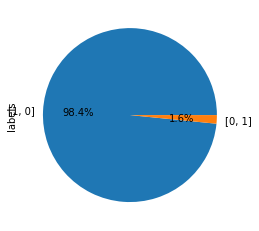

In [22]:
pd.DataFrame.from_dict(train_dataset_ent)["labels"].value_counts().plot.pie(autopct='%1.1f%%')

In [23]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
        #self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)
        self.sig = torch.nn.GELU()
        
    def forward(self, input_ids, attention_mask):
        _ , pooled_output = self.bert(input_ids=input_ids, attention_mask =attention_mask,return_dict=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        prediction = self.sig(logits)
        
        return prediction

learning_rate = 3e-5
base_model = BERTClassifier(num_classes)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)
print (base_model)

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


def train(base_model,train_dataloader,optimizer,loss_function):
    # Training loop
    num_epochs = 20
    valid_interval = 20  # Perform validation and save model every 10 iterations
    iteration = 0
    max_f1 = 0
    stop_criterion = 2000000

    running_loss = []
    for epoch in range(num_epochs):
        base_model.train()  # Set the model to training mode
        for curr_batch in train_dataloader:
            
            if iteration > stop_criterion:
                break
            
            input_ids = curr_batch['input_ids'].to(device)
            attention_mask = curr_batch['attention_mask'].to(device)
            targets = curr_batch['multi_label'].to(device)



            outputs = base_model(input_ids,attention_mask)
            loss = loss_function(outputs.to(device), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print (iteration)
            running_loss.append(loss.item())
            if len(running_loss) > 20:
                running_loss.pop(0)
            print (f"Epoch : {epoch} ,Iteration : {iteration}, training loss: {loss:.4f} , running loss:{sum(running_loss)/len(running_loss)}",find_metrics(targets,outputs))
            
            # freeing up excess memory
            del loss, outputs
            gc.collect()
            torch.cuda.empty_cache()
            
            
            # Validation and model saving
            if iteration % valid_interval == 0:
                base_model.eval()  # Set the model to evaluation mode

                with torch.no_grad():
                    total_loss = []
                    f1_micro = []
                    f1_macro = []
                    f1_avg = []
                    for val_batch in val_dataloader:
                        val_input_ids = val_batch['input_ids'].to(device)
                        val_attention_mask = val_batch['attention_mask'].to(device)
                        val_targets = val_batch['multi_label'].to(device)


                        outputs = base_model(val_input_ids,val_attention_mask)
                        loss = loss_function(outputs.to(device), val_targets)
                        
                        total_loss.append(loss.item())
                        val_out = find_metrics(val_targets,outputs)
                        f1_micro.append(val_out[0])
                        f1_macro.append(val_out[1])
                        f1_avg.append(val_out[2])
                        
                        # emptying memory
                        del val_out, loss, outputs
                        gc.collect()
                        torch.cuda.empty_cache()
                        
                    avg_acc = sum(f1_avg)/len(f1_avg)
                    avg_f1mic = sum(f1_micro)/len(f1_micro)
                    avg_f1mac = sum(f1_macro)/len(f1_macro)
                    avg_loss = sum(total_loss)/len(total_loss)
                    
                    print (f"Validation loss : {sum(total_loss)/len(total_loss)} ", ' ,acc : ',avg_acc," ,f1-micro : ",avg_f1mic," ,f1-macro : ",avg_f1mac)
                    if avg_f1mic > max_f1 :
                        torch.save(base_model.state_dict(),f"model_trained_ent/model_{iteration}.pth")
                    
                    del total_loss, f1_micro, f1_macro, f1_avg

                base_model.train()  # Set the model back to training mode
            
            iteration += 1
    return base_model, train_dataloader, optimizer, loss_function

base_model, train_dataloader, optimizer, loss_function = train(base_model,train_dataloader,optimizer,loss_function)

Epoch : 0 ,Iteration : 0, training loss: 0.7123 , running loss:0.7123226523399353 (0.3125, 0.2727272727272727, 0.125)
Validation loss : 0.5320911412184604   ,acc :  0.9863246924428822  ,f1-micro :  0.9863246924428822  ,f1-macro :  0.8997816359125855
Epoch : 0 ,Iteration : 1, training loss: 0.5414 , running loss:0.6268762052059174 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 2, training loss: 0.4408 , running loss:0.5648662149906158 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 3, training loss: 0.3826 , running loss:0.5193109810352325 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 4, training loss: 0.3644 , running loss:0.4883266806602478 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 5, training loss: 0.3488 , running loss:0.46507952610651654 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 6, training loss: 0.3386 , running loss:0.4470062383583614 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 7, training loss: 0.3347 , running loss:0.43296969681978226 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 8, training loss: 0.4263 , running loss

Epoch : 0 ,Iteration : 74, training loss: 0.3224 , running loss:0.3684811666607857 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 75, training loss: 0.3217 , running loss:0.3684185341000557 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 76, training loss: 0.4446 , running loss:0.37459479570388793 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 77, training loss: 0.3209 , running loss:0.37456677854061127 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 78, training loss: 0.3214 , running loss:0.3746860682964325 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 79, training loss: 0.4269 , running loss:0.36749381124973296 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 80, training loss: 0.3187 , running loss:0.367577888071537 (1.0, 1.0, 1.0)
Validation loss : 0.34431518823798807   ,acc :  0.9863246924428822  ,f1-micro :  0.9863246924428822  ,f1-macro :  0.8975863958717412
Epoch : 0 ,Iteration : 81, training loss: 0.3192 , running loss:0.3614093139767647 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 82, trai

Epoch : 0 ,Iteration : 148, training loss: 0.3130 , running loss:0.3566005825996399 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 149, training loss: 0.4533 , running loss:0.3636674627661705 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 150, training loss: 0.3129 , running loss:0.3637502193450928 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 151, training loss: 0.3131 , running loss:0.3637847602367401 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 152, training loss: 0.5915 , running loss:0.3621145784854889 (0.875, 0.4666666666666667, 0.875)
Epoch : 0 ,Iteration : 153, training loss: 0.3149 , running loss:0.3622889220714569 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 154, training loss: 0.3157 , running loss:0.3625084176659584 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 155, training loss: 0.4482 , running loss:0.3693493366241455 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 156, training loss: 0.3173 , running loss:0.3625118240714073 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 157, training lo

Epoch : 0 ,Iteration : 222, training loss: 0.3134 , running loss:0.33426104336977003 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 223, training loss: 0.3125 , running loss:0.33422791212797165 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 224, training loss: 0.3117 , running loss:0.32685053199529646 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 225, training loss: 0.4621 , running loss:0.33430042266845705 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 226, training loss: 0.3121 , running loss:0.33420282006263735 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 227, training loss: 0.6053 , running loss:0.3487847328186035 (0.875, 0.4666666666666667, 0.875)
Epoch : 0 ,Iteration : 228, training loss: 0.3126 , running loss:0.3487682372331619 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 229, training loss: 0.3125 , running loss:0.3487273082137108 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 230, training loss: 0.3130 , running loss:0.3487137958407402 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 231, training loss: 0.3127 , run

Epoch : 0 ,Iteration : 297, training loss: 0.3126 , running loss:0.3302080497145653 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 298, training loss: 0.3126 , running loss:0.3299016833305359 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 299, training loss: 0.3125 , running loss:0.32951015830039976 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 300, training loss: 0.4617 , running loss:0.33647816479206083 (0.9375, 0.4838709677419355, 0.9375)
Validation loss : 0.3435181659271512   ,acc :  0.9863246924428822  ,f1-micro :  0.9863246924428822  ,f1-macro :  0.8989047910423176
Epoch : 0 ,Iteration : 301, training loss: 0.3125 , running loss:0.3361387103796005 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 302, training loss: 0.3124 , running loss:0.3358432903885841 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 303, training loss: 0.3126 , running loss:0.3355100616812706 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 304, training loss: 0.3124 , running loss:0.33531482368707655 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 305, training loss: 0

In [25]:
import torch
gc.collect()
torch.cuda.empty_cache()

In [26]:
def find_metrics1(targets,prediction):
    final_pred = prediction
    np_tar = targets.cpu().detach().numpy()
    np_pred = final_pred.cpu().detach().numpy()
    
    avg_f1_mic = f1_score(np_tar.flatten(), np_pred.flatten(), average='micro',zero_division=0)
    avg_f1_mac = f1_score(np_tar, np_pred, average='macro',zero_division=1)
    avg_acc = accuracy_score(np_tar, np_pred)
    del np_tar
    del np_pred
    del final_pred
    return avg_f1_mic, avg_f1_mac, avg_acc


def test_accuracies(base_model,test_data,tokenizer_private):
    nlp = spacy.load("en_core_web_sm")
    total_acc = []
    for i in range(0,len(test_data)):
        
        old_str = test_data["text"][i]
        doc = nlp(old_str)
        old_str = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
        prediction = []
        for j in range(0,8):
            new_string = old_str[:-1] + " " + definitions[label_to_def[j]]  
            inputs = tokenizer_private.encode_plus(
                new_string,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            outputs = torch.sigmoid(base_model(inputs["input_ids"].to(device),inputs["attention_mask"].to(device))) 
            #print (outputs)
            if outputs[0][1] > outputs[0][0] :
                prediction.append(1)
            else:
                prediction.append(0)
        
        prediction = torch.tensor(prediction)
        targets = torch.zeros(8, dtype=torch.float32)
        targets[test_data["labels"][i]] = 1
        #print (prediction,targets)
        total_acc.append(find_metrics1(prediction,targets)[2])
    print (sum(total_acc)/len(total_acc))
test_accuracies(base_model,test_dataset,tokenizer)

KeyboardInterrupt: 

In [ ]:
train_1_lab = [0,1,4,5,6,7]
test_1_lab = [2,3]

train_2_lab = [0,1,4,5]
test_2_lab = [2,3,6,7]

In [ ]:
def convert_to_hidden(train_data,val_data,test_data):
    # add the multi_label with test label to the test data
    